1.) Making optimal decisions under uncertain conditions


In [6]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Building A Static Environment

In [7]:
class Environment(object):
  # in reality reward probabilities are not available we need to estimate it via various methods like incrmental average, greedy agent
  # epsilon greedy

  def __init__(self, reward_probabilities, actual_rewards):
    if len(reward_probabilities) != len(actual_rewards):
      raise Exception(f"size of reward_probabilities : {len(reward_probabilities)} does not match size of actual rewards : {len(actual_rewards)}")

    self.reward_probabilities = reward_probabilities
    self.actual_rewards = actual_rewards
    self.k_arms = len(reward_probabilities)

  def choose_arm(self, arm):
    if arm < 0 or arm >= self.k_arms:
      raise Exception(f"arm must be between 0 and {self.k_arms -1}")

    return self.actual_rewards[arm] if np.random.random() < self.reward_probabilities[arm] else 0.0

In [8]:
env = Environment(reward_probabilities=[0.62, 0.05, 0.87, 0.49], actual_rewards=[1.0, 1.0, 1.0, 1.0])

In [10]:
[env.choose_arm(1) for _ in range(10)]

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0]

In [11]:
[env.choose_arm(2) for _ in range(10)]

[1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [12]:
[env.choose_arm(0) for _ in range(10)]

[1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0]

In [13]:
[env.choose_arm(3) for _ in range(10)]

[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0]

1.) Goal is to **maximize the reward** <br/>
2.) Action values - Evaluating the action of each value <br/>




### Calculationg Average Through **Incremental Sampling**

The obvious way to calculate the average of a finite set of numbers it to sum the list of numbers and divide by the length of the list. However, it is not always feasible to store all numbers into a list before calculating their average. <br/>
The incremental sampling technique is a memory-efficient way of estimating the average of a larger collection of numbers on the fly. See the formular below and let's turn that into code :
```
 **new_estimage = old_estimate + (1/n) * (reward - old_estimate)**

```

  **n** = no of times reward receive or more generally,

```
**new_estimage = old_estimate + (step_size) * (reward - old_estimate)**
```


Now, let's translate this formula into code.


In [ ]:
## Incremental Average
count = 0
old_estimate = 0.0
while True:
  count += 1
  value = float(input("Enter a number"))
  current_estimate = old_estimate + (1/count) * (value - old_estimate)
  old_estimate = current_estimate
  print(f" Running Average : {current_estimate}")


### Incremental Sampling For Non-Stationary Bandit Problems

**new_estimage = old_estimate + (1/n) * (reward - old_estimate)**

In the incremental sampling formular above, the term **(1/n)** gets smaller as **n** gets larger. This means that, rewards from later time steps contribute little to the new estimate of the average and this makes it unfit for bandit problems with non-stationary reward distributions. <br/>

To curb this, another form of this formula with a **fixed** step size should be used. The step size must be a number between **0 and 1**. This way, rewards from later time steps contribute more to the estimation of the average and this makes it fit for non-stationary bandit problems.<br/>
The following general update rule is very common throughout Reinforcement Learning especially in Temporal Difference learning algorithms.

**new_estimage = old_estimate + (step_size) * (reward - old_estimate)**

<br/>
(reward - old_estimate) - how far we are from true estimates
Let's verify this in code.

In [17]:
time_steps = np.arange(1,50)
weights = 1/time_steps

Text(0, 0.5, 'Weights')

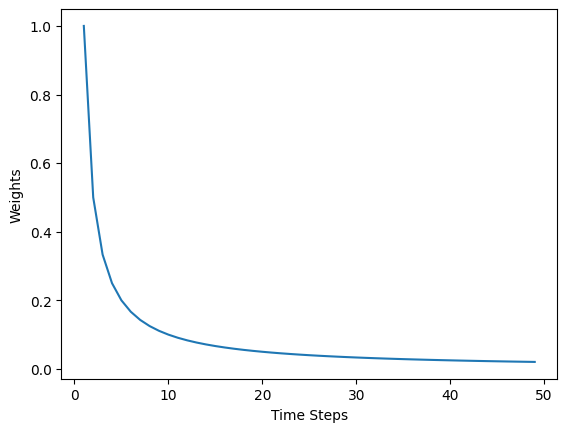

In [18]:
plt.plot(time_steps, weights)
plt.xlabel("Time Steps")
plt.ylabel("Weights")

### Implementing A Random-Behaving Agent

In [20]:
# spend life time in exploration

class RandomAgent(object):

  def __init__(self, env, max_iterations=500):
    self.env = env
    self.iterations = max_iterations

    # agent estimates of rewards probabilities
    self.q_values = np.zeros(self.env.k_arms)
    self.arm_counts = np.zeros(self.env.k_arms)
    self.arm_rewards = np.zeros(self.env.k_arms)

    self.rewards = [0.0]
    self.cum_rewards = [0.0]

  def act(self):
    for i in range(self.iterations):
      arm = np.random.choice(self.env.k_arms)
      reward = self.env.choose_arm(arm)

      self.arm_counts[arm] = self.arm_counts[arm] + 1
      self.arm_rewards[arm] = self.arm_rewards[arm] + reward

      # estimating action-value using incremental average
      self.q_values[arm] = self.q_values[arm] + (1/self.arm_counts[arm]) * (reward - self.q_values[arm])
      self.rewards.append(reward)
      self.cum_rewards.append(sum(self.rewards) / len(self.rewards))

    return {"arm_counts": self.arm_counts, "rewards": self.rewards, "cum_rewards": self.cum_rewards}



In [50]:
test_env = Environment(reward_probabilities=[0.62, 0.05, 0.87, 0.49], actual_rewards=[1.0, 1.0, 1.0, 1.0])
random_agent = RandomAgent(test_env)
random_agent_result = random_agent.act()

In [51]:
total_rewards = sum(random_agent_result["rewards"])
print(f"Total Reward : {total_rewards}")

Total Reward : 260.0


<BarContainer object of 4 artists>

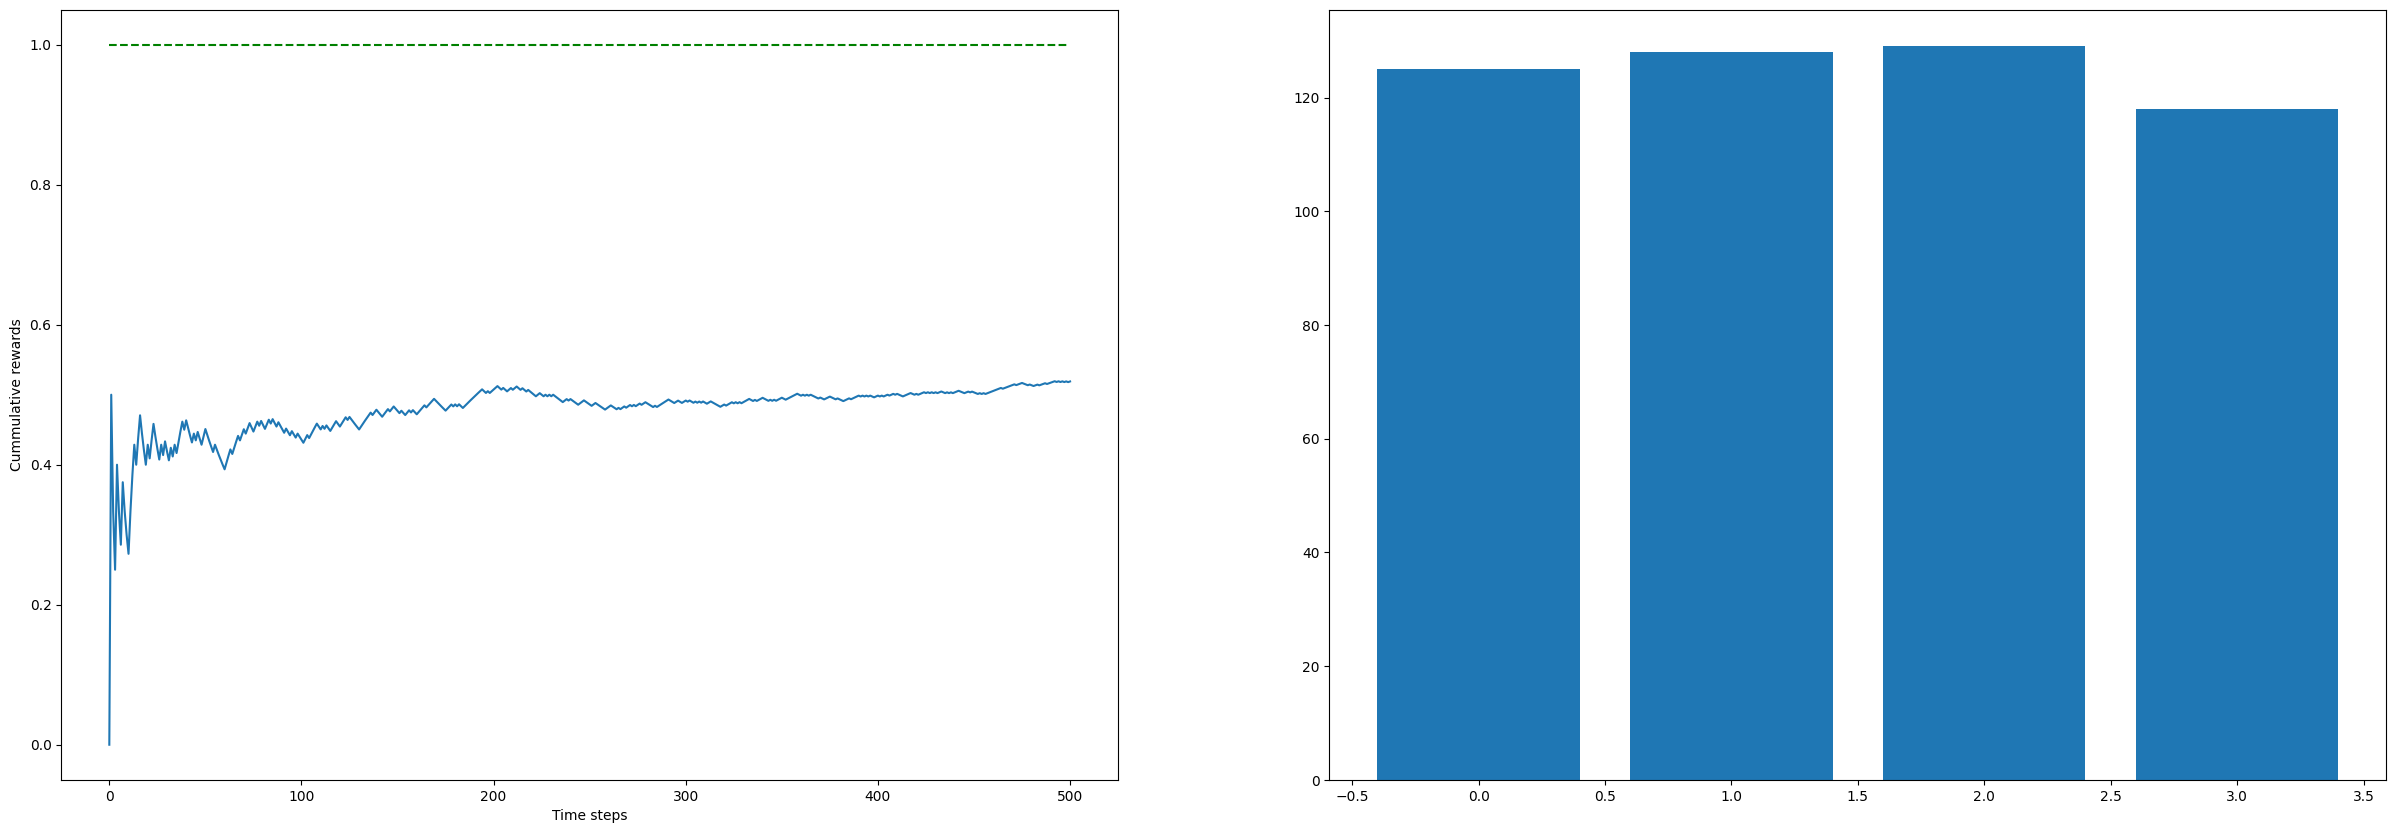

In [52]:
cum_rewards = random_agent_result["cum_rewards"]
arm_counts = random_agent_result["arm_counts"]

fig = plt.figure(figsize=[30,10])

ax1 = fig.add_subplot(121)
ax1.plot([1.0 for _ in range(random_agent.iterations)], "g--", label="target cummulative reward")
ax1.plot(cum_rewards, label="cummulative rewards")
ax1.set_xlabel("Time steps")
ax1.set_ylabel("Cummulative rewards")

ax2 = fig.add_subplot(122)
ax2.bar([i for i in range(len(arm_counts))], arm_counts)

In [53]:
print(f"Environment Reward Probabilities : {test_env.reward_probabilities}")
print(f"Random Agent Action Values : {random_agent.q_values}")

Environment Reward Probabilities : [0.62, 0.05, 0.87, 0.49]
Random Agent Action Values : [0.592      0.0546875  0.84496124 0.59322034]


### Implementing A Greedy Agent

In [54]:
# Agent Spend its life time in exploitation
# it exploits env completely without exploring
#
class GreedyAgent(object):

  def __init__(self, env, max_iterations=500):
    self.env = env
    self.iterations = max_iterations

    self.q_values = np.zeros(self.env.k_arms)
    self.arm_counts = np.zeros(self.env.k_arms)
    self.arm_rewards = np.zeros(self.env.k_arms)

    self.rewards = [0.0]
    self.cum_rewards = [0.0]

  def act(self):
    for i in range(self.iterations):
      arm = np.argmax(self.q_values) # argmax return idx with biggest value
      reward = self.env.choose_arm(arm)

      self.arm_counts[arm] = self.arm_counts[arm] + 1
      self.arm_rewards[arm] = self.arm_rewards[arm] + reward

      self.q_values[arm] = self.q_values[arm] + (1/self.arm_counts[arm]) * (reward - self.q_values[arm])
      self.rewards.append(reward)
      self.cum_rewards.append(sum(self.rewards) / len(self.rewards))

    return {"arm_counts": self.arm_counts, "rewards": self.rewards, "cum_rewards": self.cum_rewards}


In [55]:
test_env = Environment(reward_probabilities=[0.62, 0.05, 0.87, 0.49], actual_rewards=[1.0, 1.0, 1.0, 1.0])
greedy_agent = GreedyAgent(test_env)
greedy_agent_result = greedy_agent.act()

In [56]:
total_rewards = sum(greedy_agent_result["rewards"])
print(f"Total Reward : {total_rewards}")

Total Reward : 325.0


<BarContainer object of 4 artists>

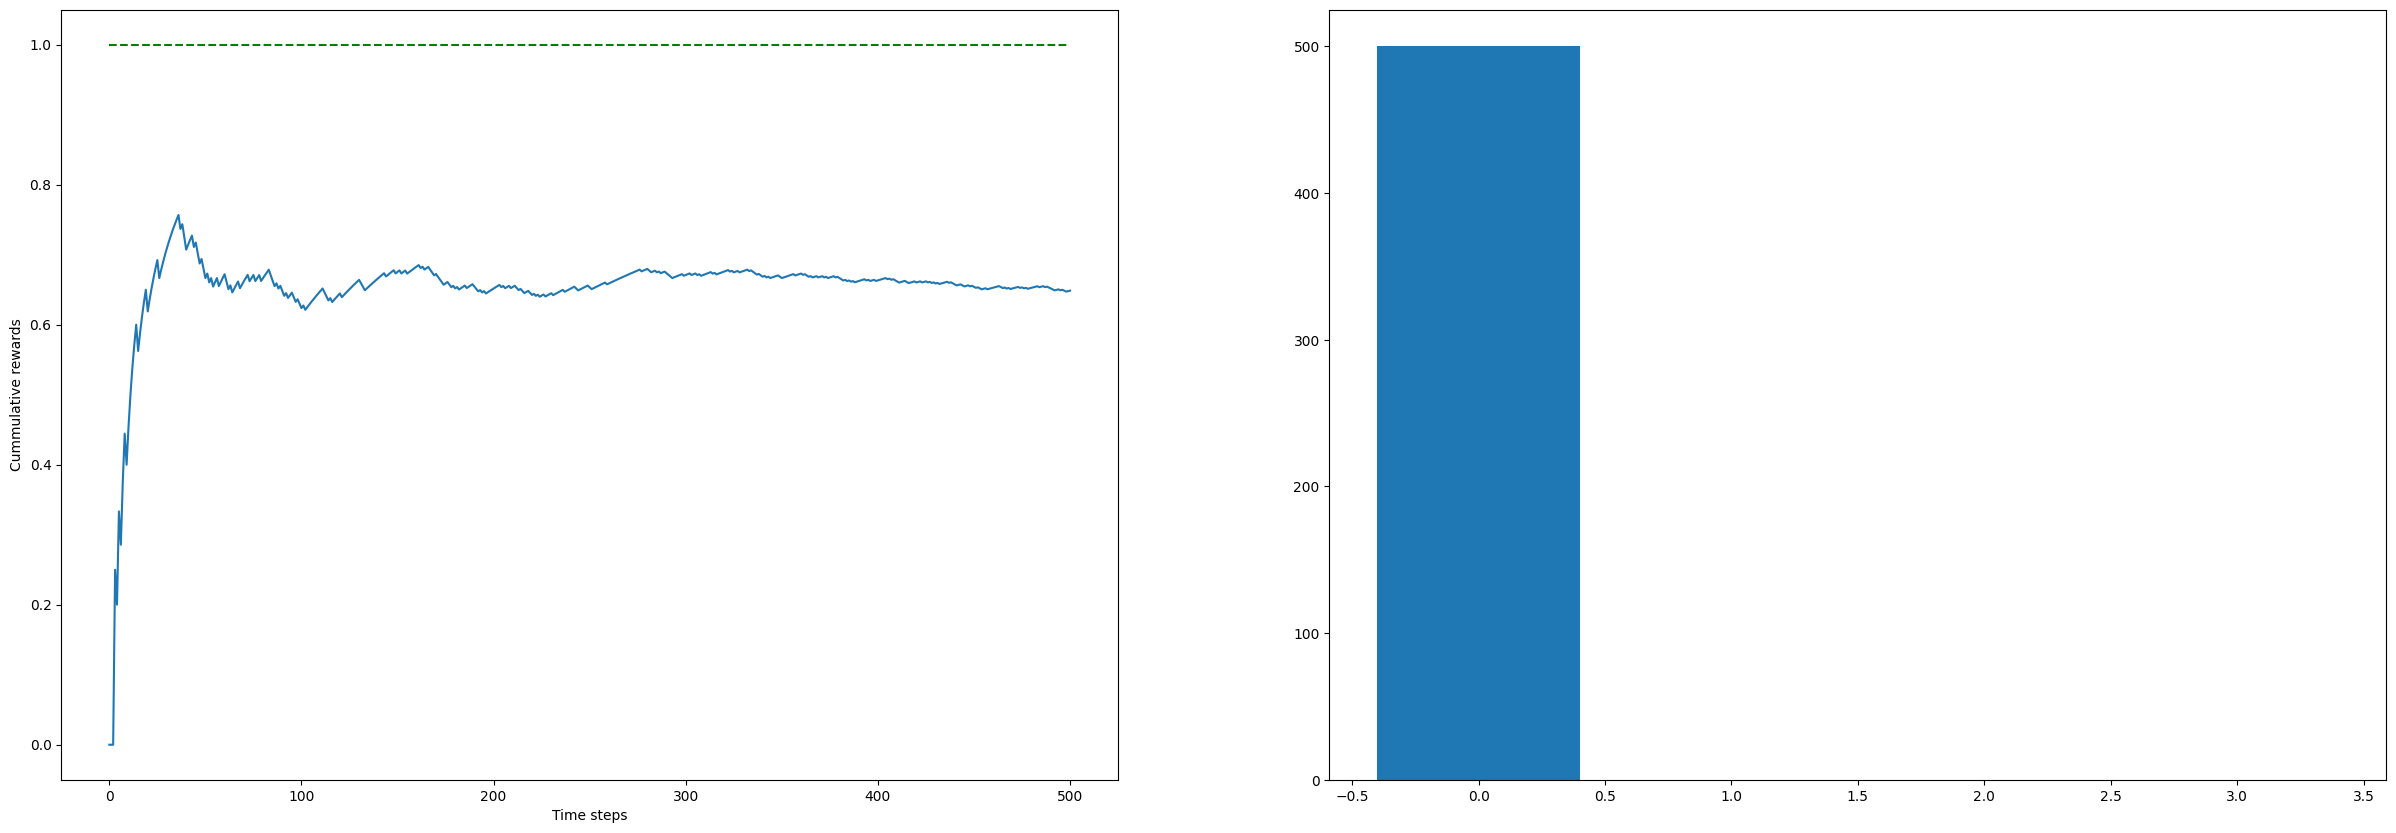

In [57]:
cum_rewards = greedy_agent_result["cum_rewards"]
arm_counts = greedy_agent_result["arm_counts"]

fig = plt.figure(figsize=[30,10])

ax1 = fig.add_subplot(121)
ax1.plot([1.0 for _ in range(greedy_agent.iterations)], "g--", label="target cummulative reward")
ax1.plot(cum_rewards, label="cummulative rewards")
ax1.set_xlabel("Time steps")
ax1.set_ylabel("Cummulative rewards")

# settled on the first actiom iteself
ax2 = fig.add_subplot(122)
ax2.bar([i for i in range(len(arm_counts))], arm_counts)

In [58]:
print(f"Environment Reward Probabilities : {test_env.reward_probabilities}")
print(f"Random Agent Action Values : {greedy_agent.q_values}")

Environment Reward Probabilities : [0.62, 0.05, 0.87, 0.49]
Random Agent Action Values : [0.65 0.   0.   0.  ]


### Balancing Exploration & Exploitation With Epsilon-Greedy Agents

<br/>

**epsilon** is the small no, which is the probability of the agent to explore and 1 - epsilon is the probability to exploit

<br/>


decay_rate and decay_interval <br/>

decay_rate slows down the exploration phase of the agent and how to decide when to slow down decay_interval is used for this



In [81]:
class EpsilonGreedyAgent(object):

  def __init__(self, env, max_iterations=500, epsilon=0.01, decay_rate=0.01, decay_interval=40):
    self.env = env
    self.iterations = max_iterations
    self.epsilon = epsilon
    self.decay_rate = decay_rate
    self.decay_interval = decay_interval

    self.q_values = np.zeros(self.env.k_arms)
    self.arm_counts = np.zeros(self.env.k_arms)
    self.arm_rewards = np.zeros(self.env.k_arms)

    self.rewards = [0.0]
    self.cum_rewards = [0.0]

  def act(self):
    for i in range(self.iterations):
      arm = np.random.choice(self.env.k_arms) if np.random.random() < self.epsilon else np.argmax(self.q_values)
      reward = self.env.choose_arm(arm)

      self.arm_counts[arm] = self.arm_counts[arm] + 1
      self.arm_rewards[arm] = self.arm_rewards[arm] + reward

      self.q_values[arm] = self.q_values[arm] + (1/self.arm_counts[arm]) * (reward - self.q_values[arm])
      self.rewards.append(reward)
      self.cum_rewards.append(sum(self.rewards) / len(self.rewards))

      if i % self.decay_interval == 0:
        self.epsilon = self.epsilon * self.decay_rate

    return {"arm_counts": self.arm_counts, "rewards": self.rewards, "cum_rewards": self.cum_rewards}


In [85]:
test_env = Environment(reward_probabilities=[0.62, 0.05, 0.87, 0.49], actual_rewards=[1.0, 1.0, 1.0, 1.0])
egreedy_agent = EpsilonGreedyAgent(test_env, epsilon=0.1, decay_rate=1.0, decay_interval=50)
egreedy_agent_result = egreedy_agent.act()

In [86]:
total_rewards = sum(egreedy_agent_result["rewards"])
print(f"Total Reward : {total_rewards}")

Total Reward : 388.0


<BarContainer object of 4 artists>

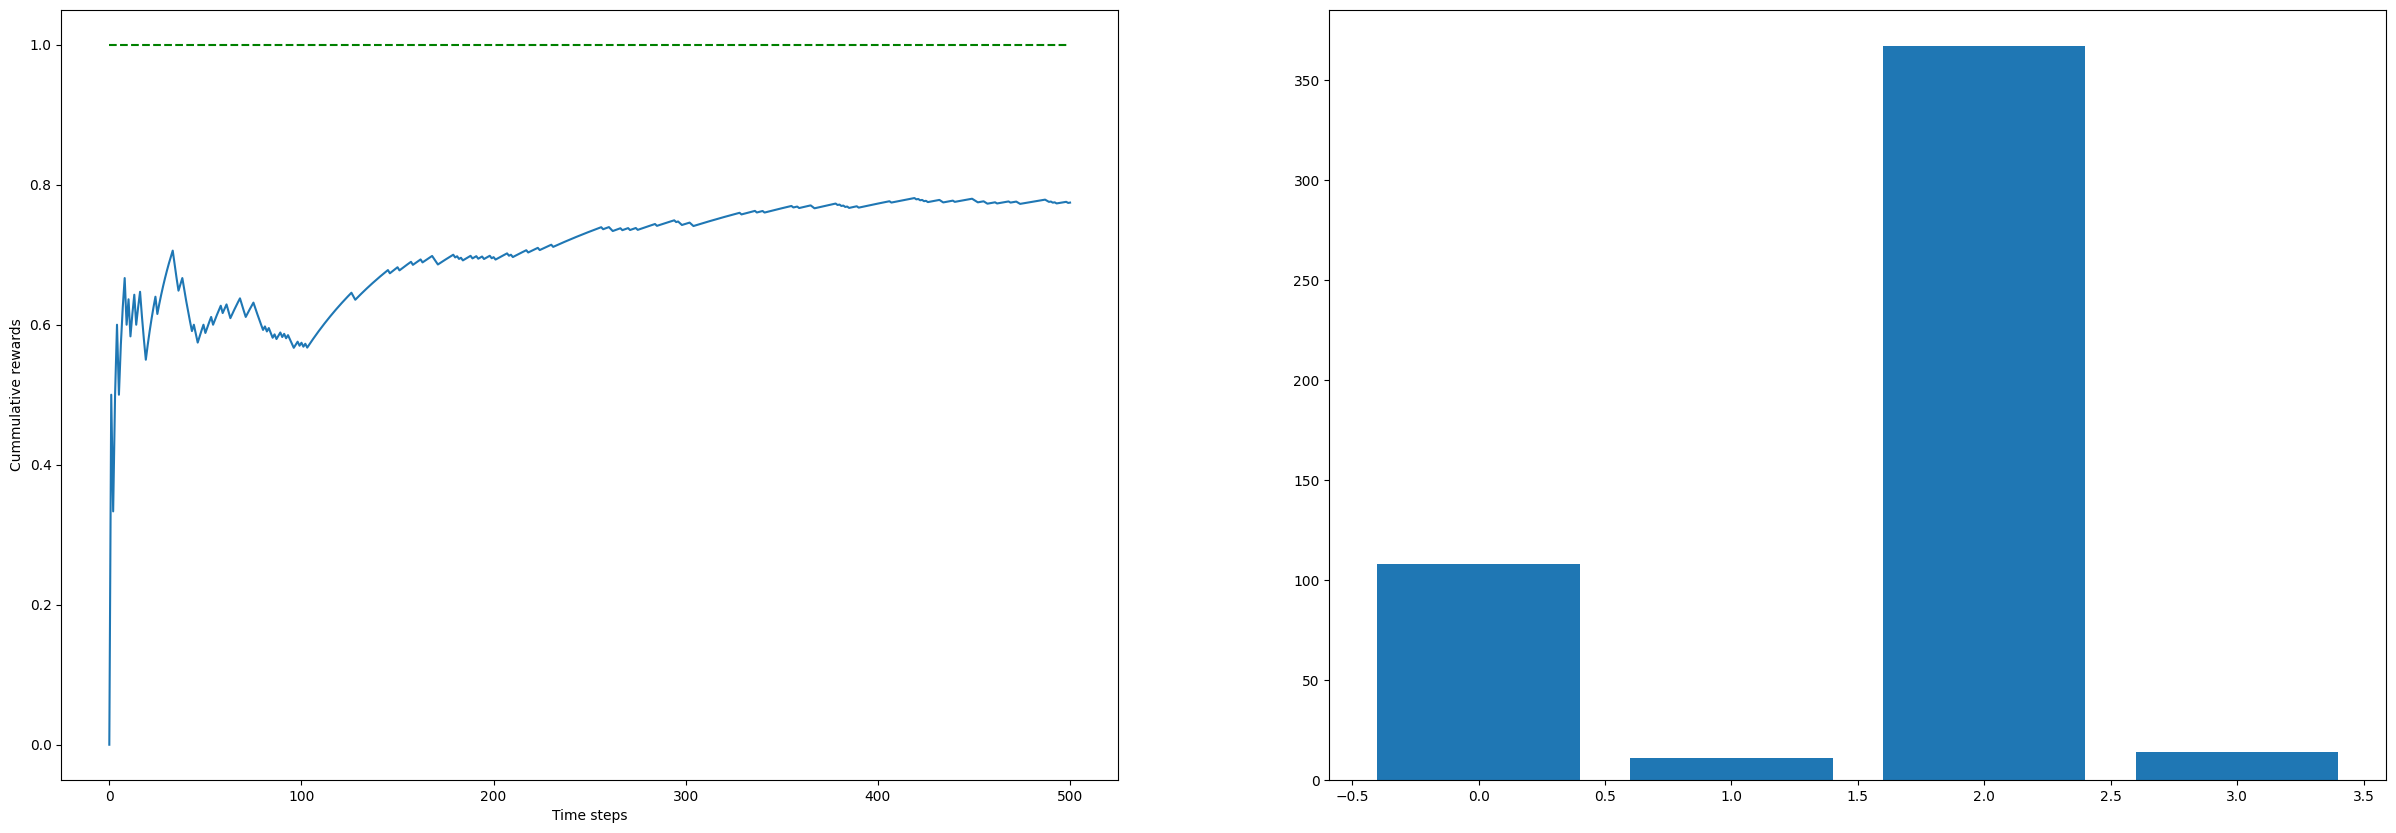

In [87]:
cum_rewards = egreedy_agent_result["cum_rewards"]
arm_counts = egreedy_agent_result["arm_counts"]

fig = plt.figure(figsize=[30,10])

ax1 = fig.add_subplot(121)
ax1.plot([1.0 for _ in range(egreedy_agent.iterations)], "g--", label="target cummulative reward")
ax1.plot(cum_rewards, label="cummulative rewards")
ax1.set_xlabel("Time steps")
ax1.set_ylabel("Cummulative rewards")

ax2 = fig.add_subplot(122)
ax2.bar([i for i in range(len(arm_counts))], arm_counts)

In [67]:
print(f"Environment Reward Probabilities : {test_env.reward_probabilities}")
print(f"Random Agent Action Values : {egreedy_agent.q_values}")

Environment Reward Probabilities : [0.62, 0.05, 0.87, 0.49]
Random Agent Action Values : [0.5        0.1        0.88695652 0.5       ]


### Intelligent Exploration With Softmax/Boltzmann Distribution

---



All non-best actions (arms) we equivalently considered in the epsilon-greedy strategy but there should be a better way. Think of medical trials for a moment. Would you randomly pick non-best medications or you'll want to be better informed?

With the Softmax Exploration algorithm, actions are selected based on the Boltzmann Distribution with the formular below :

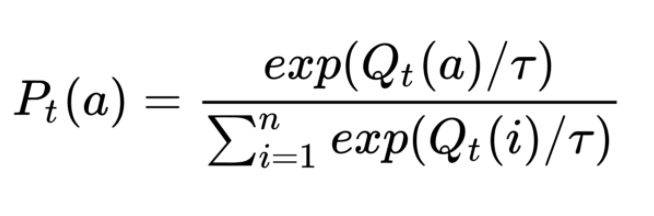

tau, the temperature factor specifies how many random arms we can explore.

In [ ]:
class SoftmaxExplorationAgent(object):

  def __init__(self, env, max_iterations=500, tau=0.5):
    self.env = env
    self.iterations = max_iterations
    self.tau = tau

    self.action_probas = np.zeros(self.env.k_arms)
    self.q_values = np.zeros(self.env.k_arms)
    self.arm_counts = np.zeros(self.env.k_arms)
    self.arm_rewards = np.zeros(self.env.k_arms)

    self.rewards = [0.0]
    self.cum_rewards = [0.0]

  def act(self):
    for i in range(self.iterations):
      self.action_probas = np.exp(self.q_values/self.tau) / np.sum(np.exp(self.q_values/self.tau))
      arm = np.random.choice(self.env.k_arms, p=self.action_probas)
      reward = self.env.choose_arm(arm)

      self.arm_counts[arm] = self.arm_counts[arm] + 1
      self.arm_rewards[arm] = self.arm_rewards[arm] + reward

      self.q_values[arm] = self.q_values[arm] + (1/self.arm_counts[arm]) * (reward - self.q_values[arm])
      self.rewards.append(reward)
      self.cum_rewards.append(sum(self.rewards) / len(self.rewards))

    return {"arm_counts": self.arm_counts, "rewards": self.rewards, "cum_rewards": self.cum_rewards}

In [ ]:
test_env = Environment(reward_probabilities=[0.62, 0.05, 0.87, 0.49], actual_rewards=[1.0, 1.0, 1.0, 1.0])
softmax_agent = SoftmaxExplorationAgent(test_env, tau=0.015, max_iterations=2000)
softmax_agent_result = softmax_agent.act()

In [ ]:
total_rewards = sum(softmax_agent_result["rewards"])
print(f"Total Reward : {total_rewards}")

Total Reward : 1732.0


<BarContainer object of 4 artists>

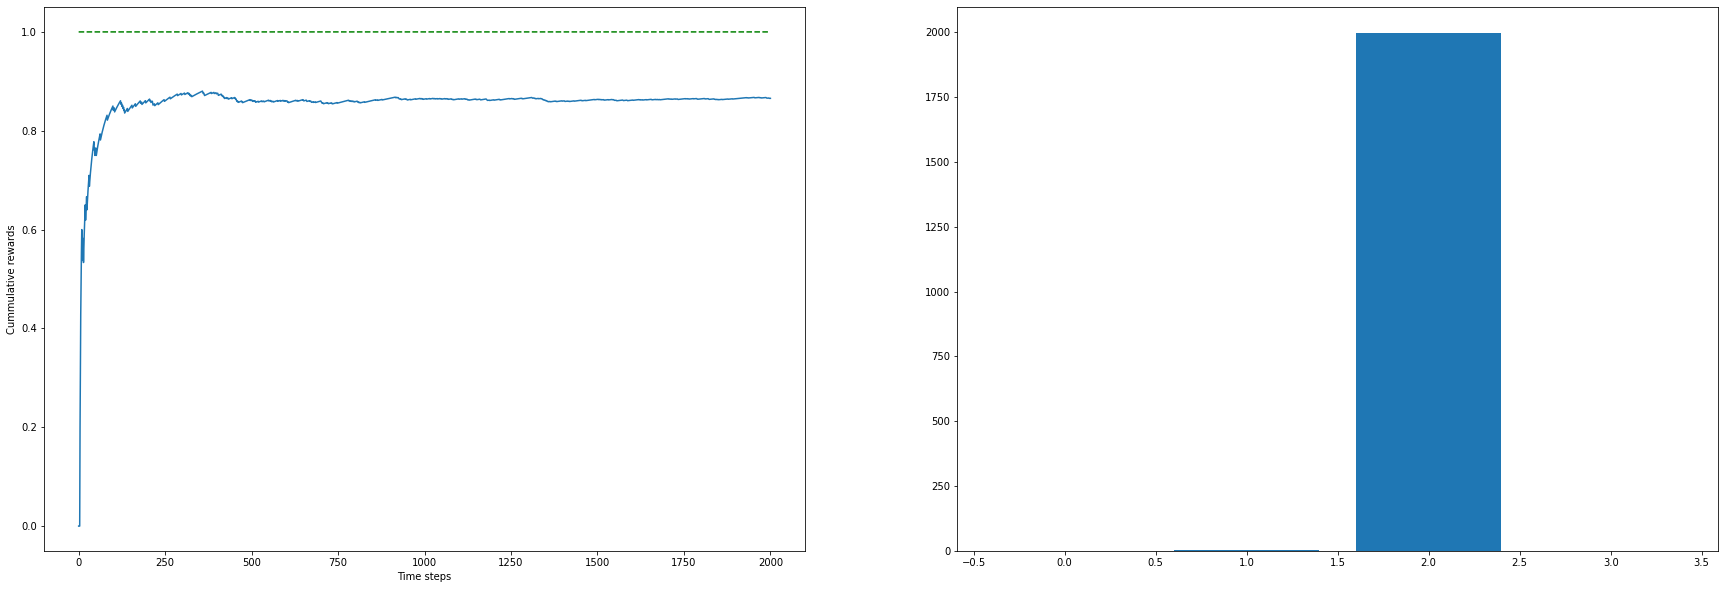

In [ ]:
cum_rewards = softmax_agent_result["cum_rewards"]
arm_counts = softmax_agent_result["arm_counts"]

fig = plt.figure(figsize=[30,10])

ax1 = fig.add_subplot(121)
ax1.plot([1.0 for _ in range(softmax_agent.iterations)], "g--", label="target cummulative reward")
ax1.plot(cum_rewards, label="cummulative rewards")
ax1.set_xlabel("Time steps")
ax1.set_ylabel("Cummulative rewards")

ax2 = fig.add_subplot(122)
ax2.bar([i for i in range(len(arm_counts))], arm_counts)

### Inducing Exploration With Optimistic Initialization (Optimism in the face of uncertainty)

In this approach, we design the agent to treat actions that have not been explored sufficiently as if they were the best actions. To do this, we have to initialize the agent's Q values to high values to make it act greedily using these estimates. To maintain the induction of exploration in the agent, we also need to initialize the arm_counts to values higher than one otherwise the Q values will change too quickly and the effect of this strategy will be reduced.

As the agent interacts with the environment and update the Q values, they will converge to their true mean/average values.



In [ ]:
class OptimisticAgent(object):

  def __init__(self, env, initial_q=1.0, initial_visits=50, max_iterations=500):
    self.env = env
    self.iterations = max_iterations
    self.initial_q = initial_q
    self.initial_visits = initial_visits

    self.q_values = np.ones(self.env.k_arms) * self.initial_q
    self.arm_counts = np.ones(self.env.k_arms) * self.initial_visits
    self.arm_rewards = np.zeros(self.env.k_arms)

    self.rewards = [0.0]
    self.cum_rewards = [0.0]

  def act(self):
    for i in range(self.iterations):
      arm = np.argmax(self.q_values)
      reward = self.env.choose_arm(arm)

      self.arm_counts[arm] = self.arm_counts[arm] + 1
      self.arm_rewards[arm] = self.arm_rewards[arm] + reward

      self.q_values[arm] = self.q_values[arm] + (1/self.arm_counts[arm]) * (reward - self.q_values[arm])
      self.rewards.append(reward)
      self.cum_rewards.append(sum(self.rewards) / len(self.rewards))

    return {"arm_counts": self.arm_counts, "rewards": self.rewards, "cum_rewards": self.cum_rewards}



In [ ]:
test_env = Environment(reward_probabilities=[0.62, 0.05, 0.87, 0.49], actual_rewards=[1.0, 1.0, 1.0, 1.0])
optimistic_agent = OptimisticAgent(test_env)
optimistic_agent_result = optimistic_agent.act()

In [ ]:
total_rewards = sum(optimistic_agent_result["rewards"])
print(f"Total Reward : {total_rewards}")

Total Reward : 421.0


<BarContainer object of 4 artists>

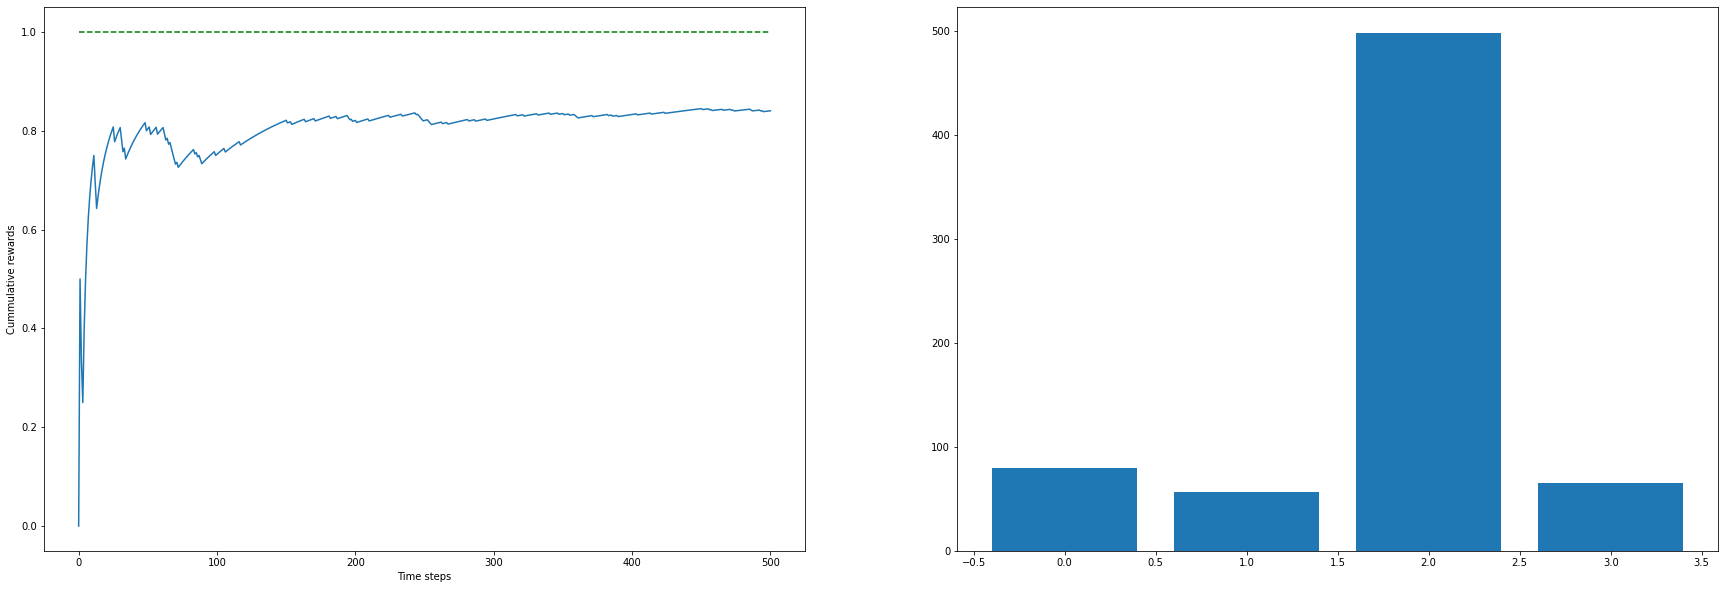

In [ ]:
cum_rewards = optimistic_agent_result["cum_rewards"]
arm_counts = optimistic_agent_result["arm_counts"]

fig = plt.figure(figsize=[30,10])

ax1 = fig.add_subplot(121)
ax1.plot([1.0 for _ in range(optimistic_agent.iterations)], "g--", label="target cummulative reward")
ax1.plot(cum_rewards, label="cummulative rewards")
ax1.set_xlabel("Time steps")
ax1.set_ylabel("Cummulative rewards")

ax2 = fig.add_subplot(122)
ax2.bar([i for i in range(len(arm_counts))], arm_counts)

In [ ]:
print(f"Environment Reward Probabilities : {test_env.reward_probabilities}")
print(f"Random Agent Action Values : {optimistic_agent.q_values}")

Environment Reward Probabilities : [0.62, 0.05, 0.87, 0.49]
Random Agent Action Values : [0.8875     0.87719298 0.88955823 0.87692308]


### Realistic Optimism With The Upper Confidence Bounds (UCB) Algorithm

There are two fundamental issues with the Optimistic Initialization strategy that we implemented in the previous section:

1. For most real-life MAB problems, we won't know the true underlying reward probabilities in order to properly initialize the Q values of the agent. If we set the Q values to be much higher than the true reward probabilities the agent will perform sub-optimally since it will take several rounds of interactions for the Q values to converge.

2. Also the initial_visits as used in the Optimistic agent represents uncertainty in our estimates and it requires tunning. Remember that there is not best way to figure out hyperparameters without experimentation and this makes it hard.

So a better strategy is to use a statistical technique to calculate the initial Q value's uncertainty and use that to influence exploration. This is called the Upper Confidence Bounds (UCB) and it is given by the formular below :

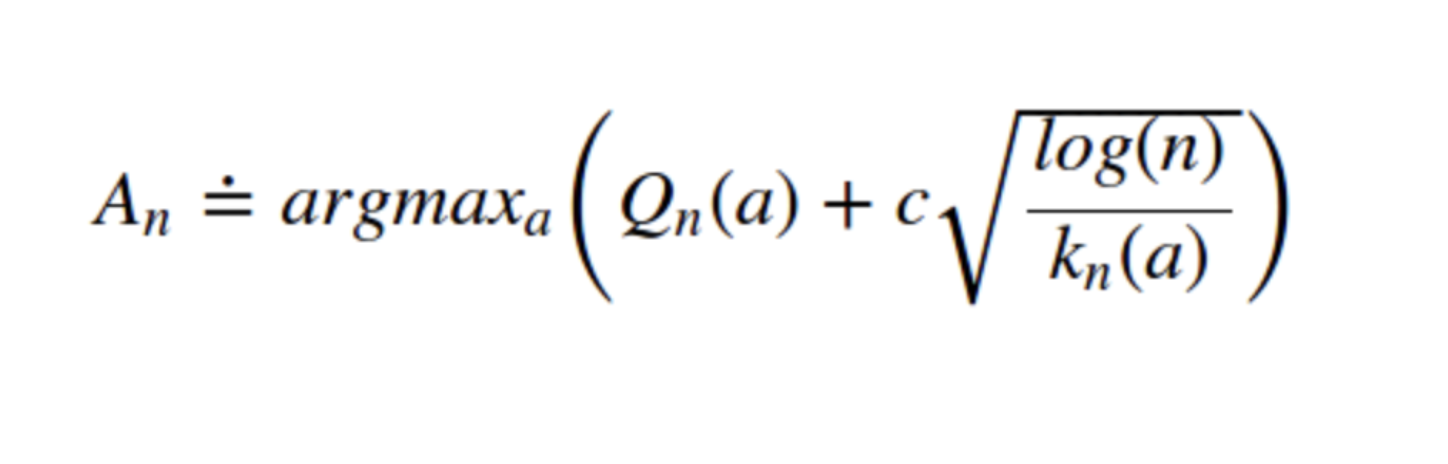

In [ ]:
class UCBAgent(object):

  def __init__(self, env, c=2, max_iterations=500):
    self.env = env
    self.c = c
    self.iterations = max_iterations

    self.q_values = np.zeros(self.env.k_arms, dtype=np.float32)
    self.arm_counts = np.zeros(self.env.k_arms, dtype=np.int)
    self.arm_rewards = np.zeros(self.env.k_arms, dtype=np.float32)

    self.rewards = [0.0]
    self.cum_rewards = [0.0]

  def act(self):
    for i in range(0, self.iterations):
      if i < len(self.q_values):
        arm = i
      else:
        U = self.c * np.sqrt(np.log(i) / self.arm_counts)
        arm = np.argmax(self.q_values + U)

      reward = self.env.choose_arm(arm)

      self.arm_rewards[arm] += reward
      self.arm_counts[arm] += 1
      self.q_values[arm] = self.q_values[arm] + (1/self.arm_counts[arm]) * (reward - self.q_values[arm])

      self.rewards.append(reward)
      self.cum_rewards.append(sum(self.rewards)/len(self.rewards))

    return {"arm_counts" : self.arm_counts, "rewards": self.rewards, "cum_rewards": self.cum_rewards}


In [ ]:
test_env = Environment(reward_probabilities=[0.62, 0.05, 0.87, 0.49], actual_rewards=[1.0, 1.0, 1.0, 1.0])
ucb_agent = UCBAgent(test_env, c=1)
ucb_agent_result = ucb_agent.act()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':


In [ ]:
total_rewards = sum(ucb_agent_result["rewards"])
print(f"Total Reward : {total_rewards}")

Total Reward : 413.0


<BarContainer object of 4 artists>

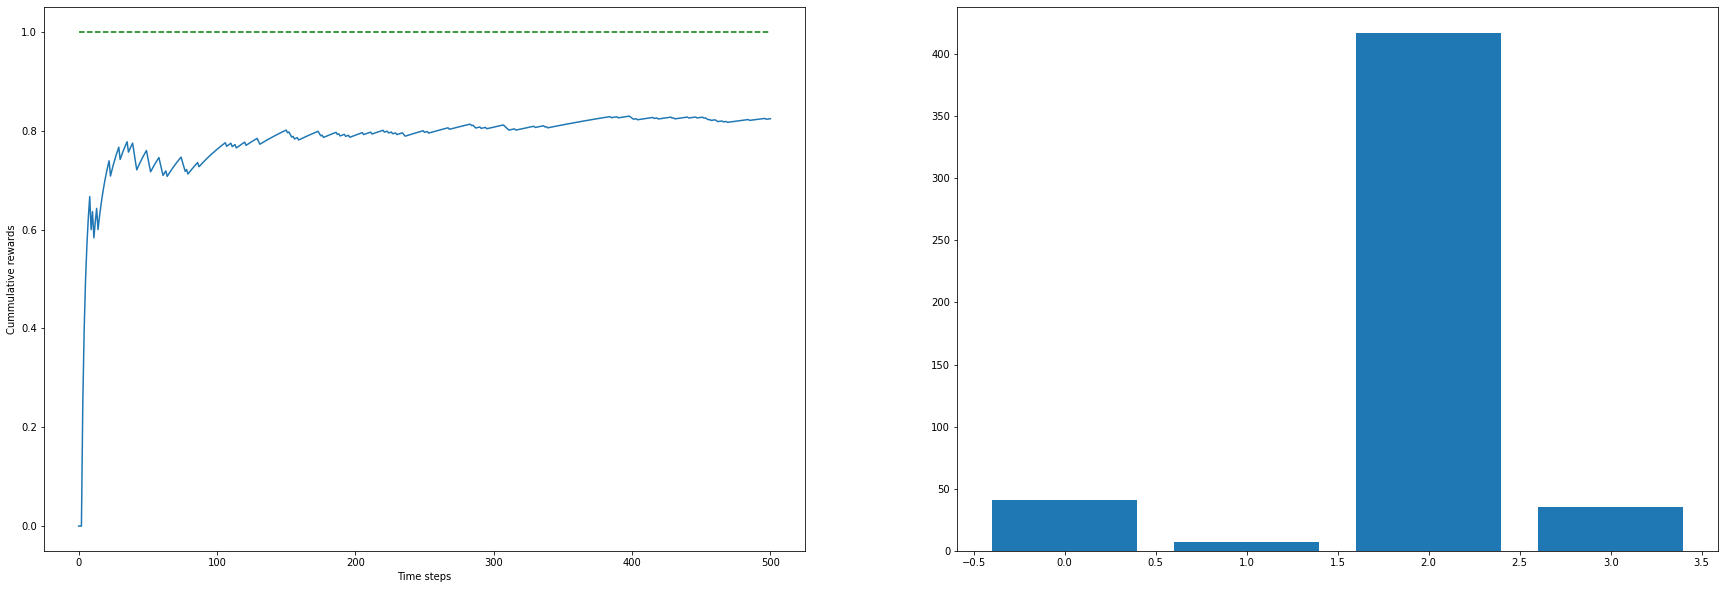

In [ ]:
cum_rewards = ucb_agent_result["cum_rewards"]
arm_counts = ucb_agent_result["arm_counts"]

fig = plt.figure(figsize=[30,10])

ax1 = fig.add_subplot(121)
ax1.plot([1.0 for _ in range(ucb_agent.iterations)], "g--", label="target cummulative reward")
ax1.plot(cum_rewards, label="cummulative rewards")
ax1.set_xlabel("Time steps")
ax1.set_ylabel("Cummulative rewards")

ax2 = fig.add_subplot(122)
ax2.bar([i for i in range(len(arm_counts))], arm_counts)

**policy** is roughly equivalent to **model** <br/>

In machine learning, the model means learned function. When someone says policy, it is more specific than model because it indicates this is a model that acts in the world.
<br/><br/>

**policy evaluation approaches** available to optimize a policy.  <br/><br/>
using --cb_type:

Inverse Propensity Score: --cb_type ips

Doubly Robust: --cb_type dr

Direct Method: --cb_type dm

Multi Task Regression/Importance Weighted Regression: --cb_type mtr

<br/><br/>

Vowpal Wabbit offers **five exploration algorithms**:

Explore-First: --first

Epsilon-Greedy: --epsilon

Bagging Explorer: --bag

Online Cover: --cover

Softmax Explorer: --softmax (only supported for --cb_explore_adf)

<br/><br/>
There are four main components to a contextual bandit problem:

Context (x): the additional information which helps in choosing action.

Action (a): the action chosen from a set of possible actions A.

Probability (p): the probability of choosing a from A.

Cost/Reward (r): the reward received for action a.




Vowpal Wabbit provides **three contextual bandits algorithms**:

<br/>
<br/>

--cb : optimize predictor based on already collected data / contextual bandits without exploratio

<br/>
<br/>

--cb_explore: maximum number of actions is known ahead of time and semantics of actions stays the same across examples

<br/>
<br/>

--cb_explore_adf: when the set of actions changes over time or have rich information for each action.




vowpal format:  **action:cost:probability | features**

In [1]:
!pip install vowpalwabbit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 50.7 MB/s eta 0:00:00


In [4]:
import vowpalwabbit
import pandas as pd


In [3]:
model = vowpalwabbit.Workspace(quiet=True)

In [7]:
train_data = [
    {
        "action": 1,
        "cost": 2,
        "probability": 0.4,
        "feature1": "a",
        "feature2": "c",
        "feature3": "",
    },
    {
        "action": 3,
        "cost": 0,
        "probability": 0.2,
        "feature1": "b",
        "feature2": "d",
        "feature3": "",
    },
    {
        "action": 4,
        "cost": 1,
        "probability": 0.5,
        "feature1": "a",
        "feature2": "b",
        "feature3": "",
    },
    {
        "action": 2,
        "cost": 1,
        "probability": 0.3,
        "feature1": "a",
        "feature2": "b",
        "feature3": "c",
    },
    {
        "action": 3,
        "cost": 1,
        "probability": 0.7,
        "feature1": "a",
        "feature2": "d",
        "feature3": "",
    },
]

train_df = pd.DataFrame(train_data)

# Add index to data frame
train_df["index"] = range(1, len(train_df) + 1)
train_df = train_df.set_index("index")
train_df.head()

,action,cost,probability,feature1,feature2,feature3
index,,,,,,
1,1,2,0.4,a,c,
2,3,0,0.2,b,d,
3,4,1,0.5,a,b,
4,2,1,0.3,a,b,c
5,3,1,0.7,a,d,


In [15]:
test_data = [
    {"feature1": "a", "feature2": "c", "feature3": ""},
    {"feature1": "a", "feature2": "", "feature3": "b"},
    {"feature1": "a", "feature2": "b", "feature3": ""},
    {"feature1": "a", "feature2": "", "feature3": "b"},
]

test_df = pd.DataFrame(test_data)

# Add index to data frame
test_df["index"] = range(1, len(test_df) + 1)
test_df = test_df.set_index("index")

In [16]:
test_df.head()


,feature1,feature2,feature3
index,,,
1,a,c,
2,a,,b
3,a,b,
4,a,,b


In [10]:
# contextual bandit module and data has a total of four actions.
vw = vowpalwabbit.Workspace("--cb 4", quiet=True)

In [11]:
for i in train_df.index:
    action = train_df.loc[i, "action"]
    cost = train_df.loc[i, "cost"]
    probability = train_df.loc[i, "probability"]
    feature1 = train_df.loc[i, "feature1"]
    feature2 = train_df.loc[i, "feature2"]
    feature3 = train_df.loc[i, "feature3"]

    # Construct the example in the required vw format.
    learn_example = (
        str(action)
        + ":"
        + str(cost)
        + ":"
        + str(probability)
        + " | "
        + str(feature1)
        + " "
        + str(feature2)
        + " "
        + str(feature3)
    )
    print(learn_example)

    # Here we do the actual learning.
    vw.learn(learn_example)

1:2:0.4 | a c 
3:0:0.2 | b d 
4:1:0.5 | a b 
2:1:0.3 | a b c
3:1:0.7 | a d 


In [17]:
for j in test_df.index:
    feature1 = test_df.loc[j, "feature1"]
    feature2 = test_df.loc[j, "feature2"]
    feature3 = test_df.loc[j, "feature3"]

    test_example = "| " + str(feature1) + " " + str(feature2) + " " + str(feature3)
    # print(test_example)

    choice = vw.predict(test_example)
    print(test_example,j, choice)

| a c  1 3
| a  b 2 3
| a b  3 3
| a  b 4 3


In [18]:
import vowpalwabbit
import random
import matplotlib.pyplot as plt
import pandas as pd
import itertools


In [19]:
# VW tries to minimize loss/cost, therefore we will pass cost as -reward
USER_LIKED_ARTICLE = -1.0
USER_DISLIKED_ARTICLE = 0.0

In [20]:
def get_cost(context, action):
    if context["user"] == "Tom":
        if context["time_of_day"] == "morning" and action == "politics":
            return USER_LIKED_ARTICLE
        elif context["time_of_day"] == "afternoon" and action == "music":
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
    elif context["user"] == "Anna":
        if context["time_of_day"] == "morning" and action == "sports":
            return USER_LIKED_ARTICLE
        elif context["time_of_day"] == "afternoon" and action == "politics":
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE

In [21]:
# This function modifies (context, action, cost, probability) to VW friendly format
def to_vw_example_format(context, actions, cb_label=None):
    if cb_label is not None:
        chosen_action, cost, prob = cb_label
    example_string = ""
    example_string += "shared |User user={} time_of_day={}\n".format(
        context["user"], context["time_of_day"]
    )
    for action in actions:
        if cb_label is not None and action == chosen_action:
            example_string += "0:{}:{} ".format(cost, prob)
        example_string += "|Action article={} \n".format(action)
    # Strip the last newline
    return example_string[:-1]

In [22]:
context = {"user": "Tom", "time_of_day": "morning"}
actions = ["politics", "sports", "music", "food"]

print(to_vw_example_format(context, actions))

shared |User user=Tom time_of_day=morning
|Action article=politics 
|Action article=sports 
|Action article=music 
|Action article=food 


In [23]:
def sample_custom_pmf(pmf):
    total = sum(pmf)
    scale = 1 / total
    pmf = [x * scale for x in pmf]
    draw = random.random()
    sum_prob = 0.0
    for index, prob in enumerate(pmf):
        sum_prob += prob
        if sum_prob > draw:
            return index, prob

In [24]:
def get_action(vw, context, actions):
    vw_text_example = to_vw_example_format(context, actions)
    pmf = vw.predict(vw_text_example)
    chosen_action_index, prob = sample_custom_pmf(pmf)
    return actions[chosen_action_index], prob

In [25]:
users = ["Tom", "Anna"]
times_of_day = ["morning", "afternoon"]
actions = ["politics", "sports", "music", "food", "finance", "health", "camping"]


def choose_user(users):
    return random.choice(users)


def choose_time_of_day(times_of_day):
    return random.choice(times_of_day)


# display preference matrix
def get_preference_matrix(cost_fun):
    def expand_grid(data_dict):
        rows = itertools.product(*data_dict.values())
        return pd.DataFrame.from_records(rows, columns=data_dict.keys())

    df = expand_grid({"users": users, "times_of_day": times_of_day, "actions": actions})
    df["cost"] = df.apply(
        lambda r: cost_fun({"user": r[0], "time_of_day": r[1]}, r[2]), axis=1
    )

    return df.pivot_table(
        index=["users", "times_of_day"], columns="actions", values="cost"
    )


get_preference_matrix(get_cost)

<ipython-input-25-1249cbff866a>:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lambda r: cost_fun({"user": r[0], "time_of_day": r[1]}, r[2]), axis=1


actions             camping  finance  food  health  music  politics  sports
users times_of_day                                                         
Anna  afternoon         0.0      0.0   0.0     0.0    0.0      -1.0     0.0
      morning           0.0      0.0   0.0     0.0    0.0       0.0    -1.0
Tom   afternoon         0.0      0.0   0.0     0.0   -1.0       0.0     0.0
      morning           0.0      0.0   0.0     0.0    0.0      -1.0     0.0

In [26]:
def run_simulation(
    vw, num_iterations, users, times_of_day, actions, cost_function, do_learn=True
):
    cost_sum = 0.0
    ctr = []

    for i in range(1, num_iterations + 1):
        # 1. In each simulation choose a user
        user = choose_user(users)
        # 2. Choose time of day for a given user
        time_of_day = choose_time_of_day(times_of_day)

        # 3. Pass context to vw to get an action
        context = {"user": user, "time_of_day": time_of_day}
        action, prob = get_action(vw, context, actions)

        # 4. Get cost of the action we chose
        cost = cost_function(context, action)
        cost_sum += cost

        if do_learn:
            # 5. Inform VW of what happened so we can learn from it
            vw_format = vw.parse(
                to_vw_example_format(context, actions, (action, cost, prob)),
                vowpalwabbit.LabelType.CONTEXTUAL_BANDIT,
            )
            # 6. Learn
            vw.learn(vw_format)

        # We negate this so that on the plot instead of minimizing cost, we are maximizing reward
        ctr.append(-1 * cost_sum / i)

    return ctr

In [27]:
def plot_ctr(num_iterations, ctr):
    plt.plot(range(1, num_iterations + 1), ctr)
    plt.xlabel("num_iterations", fontsize=14)
    plt.ylabel("ctr", fontsize=14)
    plt.ylim([0, 1])

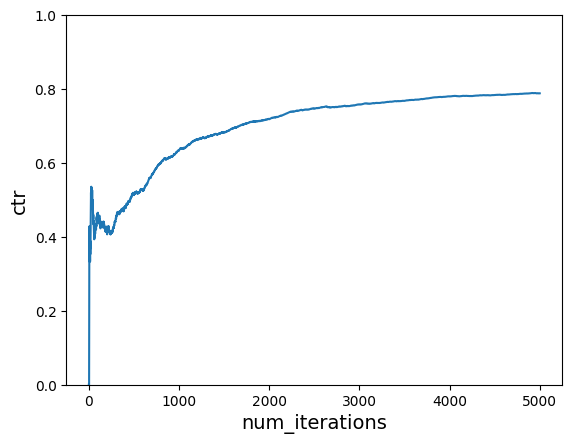

In [28]:
# Instantiate learner in VW
vw = vowpalwabbit.Workspace("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations = 5000
ctr = run_simulation(vw, num_iterations, users, times_of_day, actions, get_cost)

plot_ctr(num_iterations, ctr)